In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import sys
import glob

In [3]:
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [4]:
IMG_SIZE = (224, 224)

def load_image_mask(image_path, mask_path):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32)/255.0
    
    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method='nearest')
    mask = tf.cast(mask>0, tf.float32)
    
    return image, mask

In [5]:
image_dir = '/Users/alex/Desktop/NeuroRex/data/mri_tumor_segmentation/images'
mask_dir = '/Users/alex/Desktop/NeuroRex/data/mri_tumor_segmentation/masks'

In [6]:
image_paths = sorted(glob.glob(os.path.join(image_dir, '*.png')), key=lambda x: int(os.path.basename(x).split('.')[0]))
mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.png')), key=lambda x: int(os.path.basename(x).split('.')[0]))

In [7]:
train_img, temp_img, train_mask, temp_mask = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

In [8]:
val_img, test_img, val_mask, test_mask = train_test_split(temp_img, temp_mask, test_size=0.5, random_state=42)

In [9]:
def make_dataset(img_ds, mask_ds, batch_size=16, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((img_ds, mask_ds))
    dataset = dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [10]:
train_ds = make_dataset(train_img, train_mask)
val_ds = make_dataset(val_img, val_mask, shuffle=False)
test_ds = make_dataset(test_img, test_mask, shuffle=False)

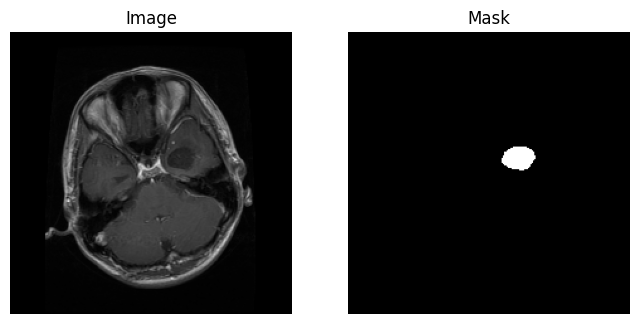

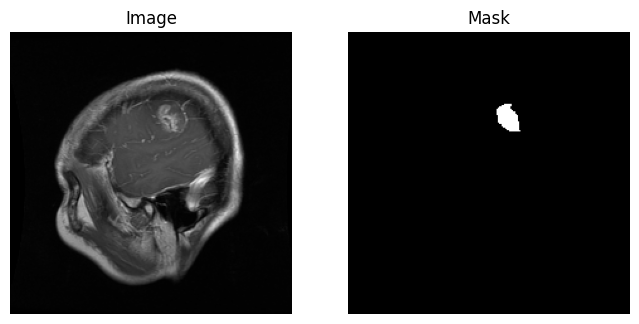

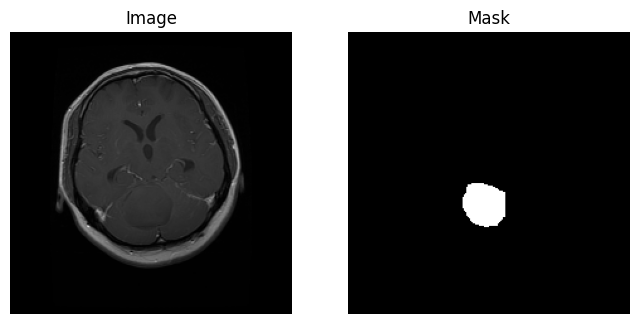

In [11]:
def visualize_batch(dataset, num=3):
    for images, masks in dataset.take(1):
        for i in range(num):
            plt.figure(figsize=(8,4))
            plt.subplot(1, 2, 1)
            plt.imshow(images[i])
            plt.title('Image')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(tf.squeeze(masks[i]), cmap='gray')
            plt.title('Mask')
            plt.axis('off')
            plt.show()

visualize_batch(train_ds)

In [12]:
from models.mri_tumor_segmentation.u_net import unet_model

model = unet_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [13]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f*y_pred_f)
    return 1-(2.*intersection+smooth)/(tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)+smooth)

In [14]:
def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce+d_loss

In [15]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f*y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(1e-3),
              loss=combined_loss,
              metrics=['accuracy', dice_coef])


In [16]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_dice_coef',
    patience=5,
    mode='max',
    restore_best_weights=True
)

TRAINING PERFORMED ON GOOGLE COLAB GPU

In [17]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Redefine dice_coef exactly how it was used
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    denominator = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    return (2. * intersection + smooth) / (denominator + smooth)

# If you used custom loss too:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    denominator = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    return 1 - (2. * intersection + smooth) / (denominator + smooth)

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)


In [18]:
model = load_model("/Users/alex/Desktop/NeuroRex/models/mri_tumor_segmentation/segmentation_model.keras",
                   custom_objects={'dice_coef': dice_coef, 'combined_loss': combined_loss})

TypeError: Could not deserialize class 'Functional' because its parent module keras.src.models.functional cannot be imported. Full object config: {'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'functional', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None, 'name': 'input_layer', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}, 'name': 'conv2d', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 3], 'dtype': 'float32', 'keras_history': ['input_layer', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 64]}, 'name': 'conv2d_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 64], 'dtype': 'float32', 'keras_history': ['conv2d', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'name': 'max_pooling2d', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 64], 'dtype': 'float32', 'keras_history': ['conv2d_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 64]}, 'name': 'conv2d_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 64], 'dtype': 'float32', 'keras_history': ['max_pooling2d', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 128]}, 'name': 'conv2d_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 128], 'dtype': 'float32', 'keras_history': ['conv2d_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'name': 'max_pooling2d_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 128], 'dtype': 'float32', 'keras_history': ['conv2d_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 128]}, 'name': 'conv2d_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 128], 'dtype': 'float32', 'keras_history': ['max_pooling2d_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2d_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 256], 'dtype': 'float32', 'keras_history': ['conv2d_4', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'name': 'max_pooling2d_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 256], 'dtype': 'float32', 'keras_history': ['conv2d_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}, 'name': 'conv2d_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 256], 'dtype': 'float32', 'keras_history': ['max_pooling2d_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv2d_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 512], 'dtype': 'float32', 'keras_history': ['conv2d_6', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'name': 'max_pooling2d_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 512], 'dtype': 'float32', 'keras_history': ['conv2d_7', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 1024, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}, 'name': 'conv2d_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 512], 'dtype': 'float32', 'keras_history': ['max_pooling2d_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 1024, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv2d_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 1024], 'dtype': 'float32', 'keras_history': ['conv2d_8', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 512, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 1024]}, 'name': 'conv2d_transpose', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 14, 14, 1024], 'dtype': 'float32', 'keras_history': ['conv2d_9', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 512], [None, 28, 28, 512]]}, 'name': 'concatenate', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 512], 'dtype': 'float32', 'keras_history': ['conv2d_transpose', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 512], 'dtype': 'float32', 'keras_history': ['conv2d_7', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 1024]}, 'name': 'conv2d_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 1024], 'dtype': 'float32', 'keras_history': ['concatenate', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_11', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv2d_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 512], 'dtype': 'float32', 'keras_history': ['conv2d_10', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 256, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 512]}, 'name': 'conv2d_transpose_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 28, 28, 512], 'dtype': 'float32', 'keras_history': ['conv2d_11', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 56, 56, 256], [None, 56, 56, 256]]}, 'name': 'concatenate_1', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 256], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_1', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 256], 'dtype': 'float32', 'keras_history': ['conv2d_5', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 512]}, 'name': 'conv2d_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 512], 'dtype': 'float32', 'keras_history': ['concatenate_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_13', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2d_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 256], 'dtype': 'float32', 'keras_history': ['conv2d_12', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 128, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 256]}, 'name': 'conv2d_transpose_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 56, 56, 256], 'dtype': 'float32', 'keras_history': ['conv2d_13', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 112, 112, 128], [None, 112, 112, 128]]}, 'name': 'concatenate_2', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 128], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_2', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 128], 'dtype': 'float32', 'keras_history': ['conv2d_3', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_14', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 256]}, 'name': 'conv2d_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 256], 'dtype': 'float32', 'keras_history': ['concatenate_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_15', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 128]}, 'name': 'conv2d_15', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 128], 'dtype': 'float32', 'keras_history': ['conv2d_14', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 64, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 128]}, 'name': 'conv2d_transpose_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 112, 112, 128], 'dtype': 'float32', 'keras_history': ['conv2d_15', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 224, 224, 64], [None, 224, 224, 64]]}, 'name': 'concatenate_3', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 64], 'dtype': 'float32', 'keras_history': ['conv2d_transpose_3', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 64], 'dtype': 'float32', 'keras_history': ['conv2d_1', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_16', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 128]}, 'name': 'conv2d_16', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 128], 'dtype': 'float32', 'keras_history': ['concatenate_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_17', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 64]}, 'name': 'conv2d_17', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 64], 'dtype': 'float32', 'keras_history': ['conv2d_16', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_18', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 136774705226960}, 'filters': 1, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 64]}, 'name': 'conv2d_18', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 64], 'dtype': 'float32', 'keras_history': ['conv2d_17', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer', 0, 0]], 'output_layers': [['conv2d_18', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'loss': {'module': 'builtins', 'class_name': 'function', 'config': 'combined_loss', 'registered_name': 'function'}, 'loss_weights': None, 'metrics': ['accuracy', {'module': 'builtins', 'class_name': 'function', 'config': 'dice_coef', 'registered_name': 'function'}], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}

In [ ]:
model.evaluate(test_ds)